In [55]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import glob
import cv2

In [3]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [33]:
image = plt.imread('01.bmp')

In [62]:
roi_bounds = pd.read_csv('ROI_bounds.csv', )

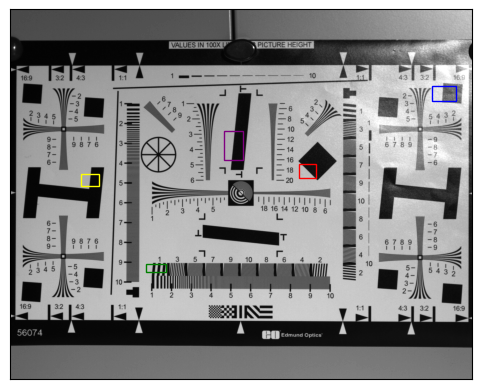

In [61]:
colors = ['red', 'blue', 'yellow', 'green', 'purple']
plt.imshow(image, cmap = 'gray')
for i in roi_bounds.index:
    plt.gca().add_patch(patches.Rectangle((roi_bounds.iloc[i][0],roi_bounds.iloc[i][1]),
                                          roi_bounds.iloc[i][2],roi_bounds.iloc[i][3],
                                          linewidth=1,edgecolor=colors[i],facecolor='none'))
plt.xticks([])
plt.yticks([])
plt.savefig('image_w_ROI.png', dpi = 300, bbox_inches = 'tight')
plt.show()

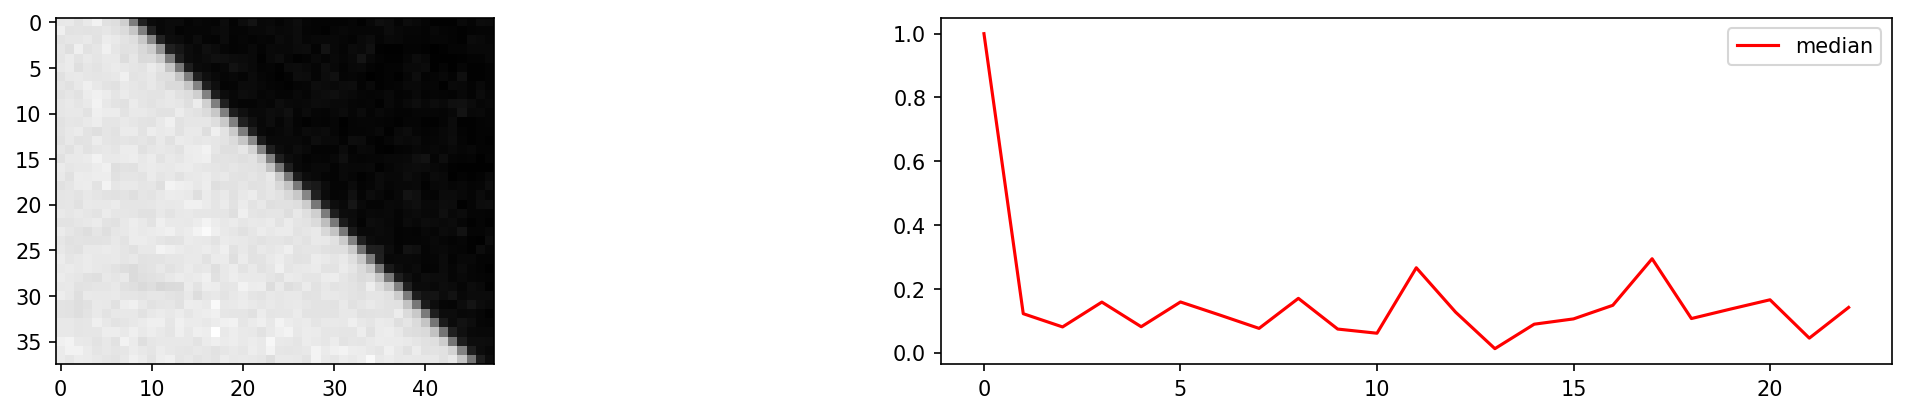

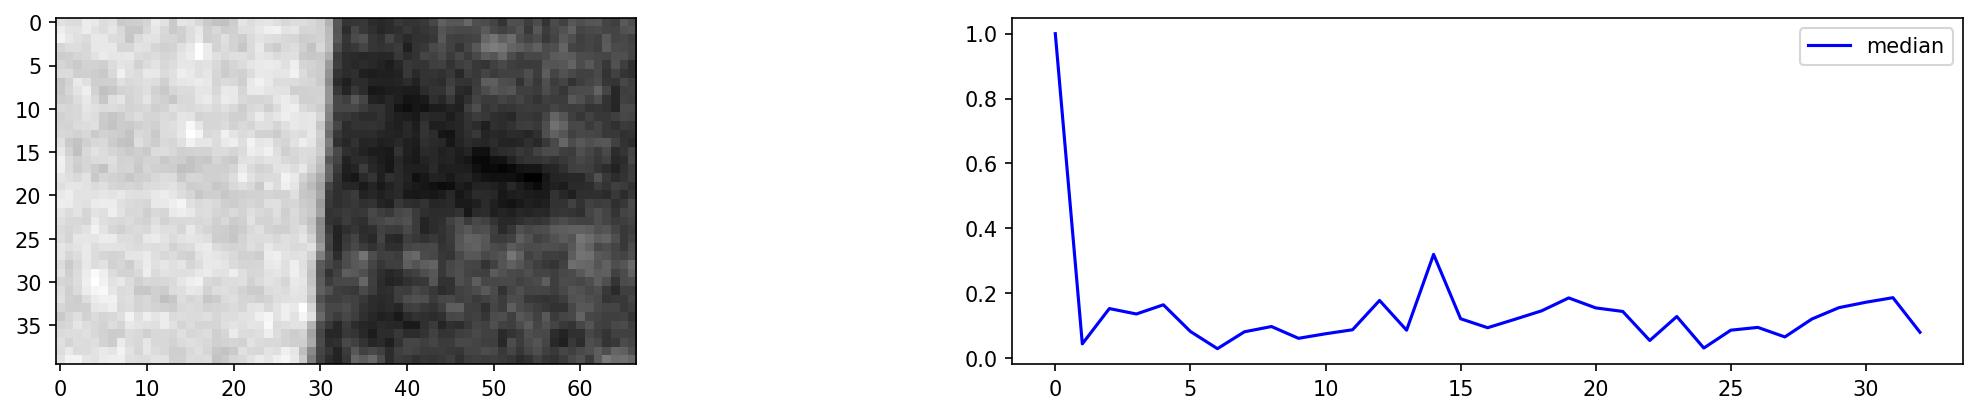

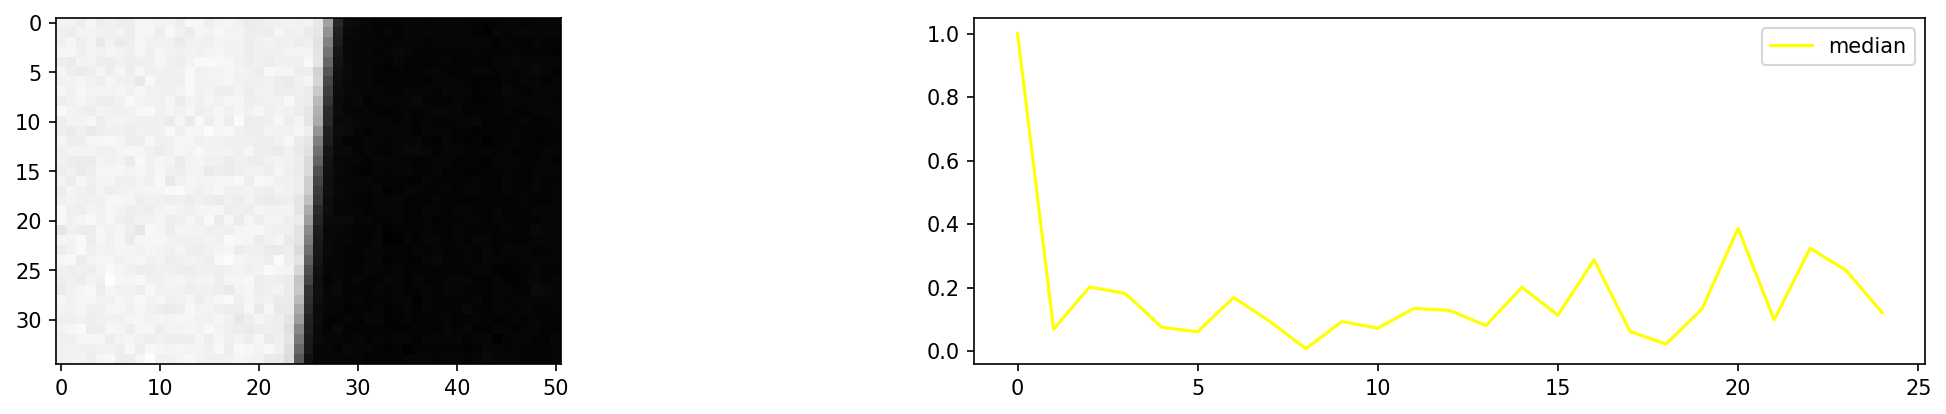

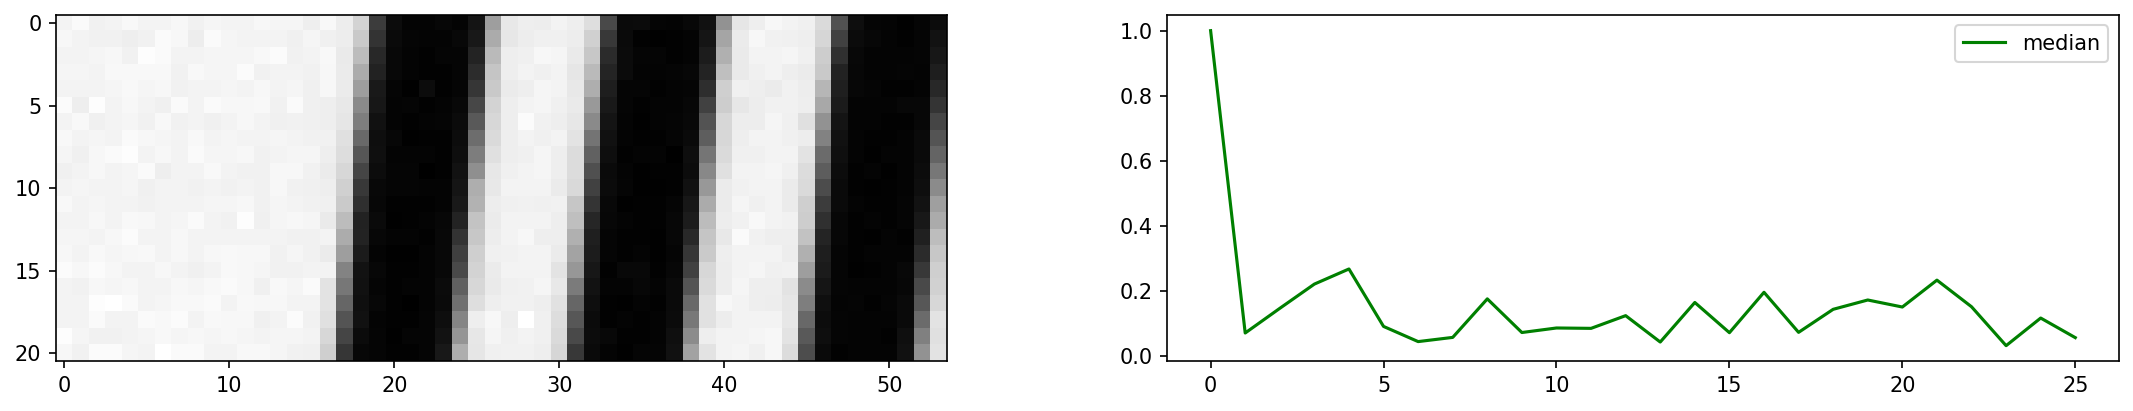

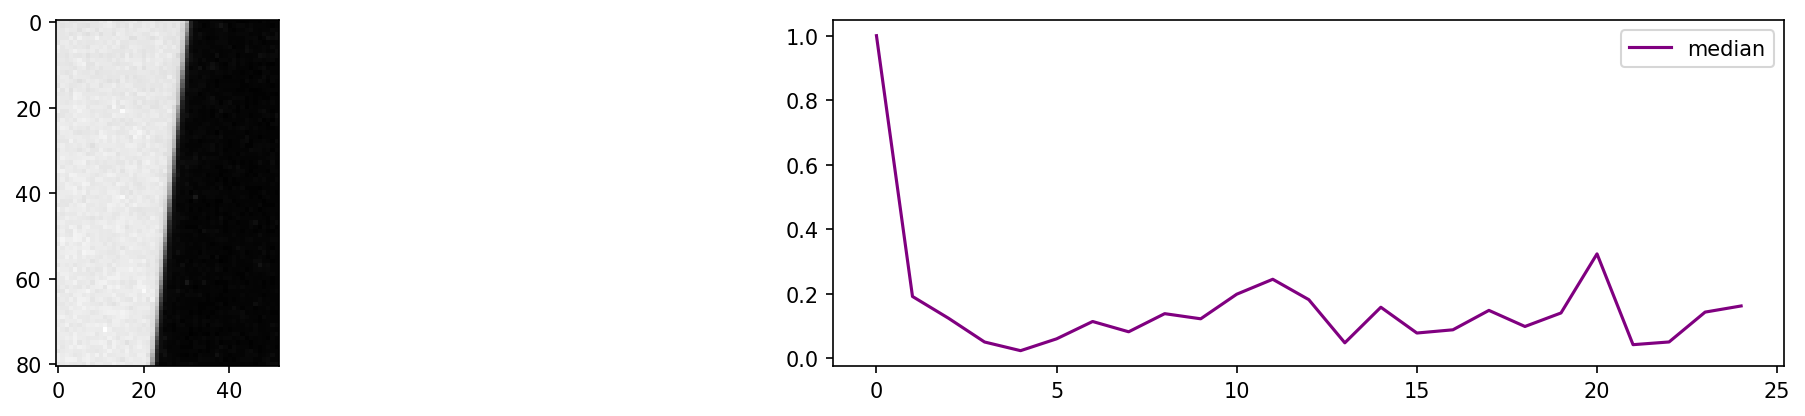

In [74]:
for i in roi_bounds.index:
    ROI = image[int(roi_bounds.iloc[i][1]):int(roi_bounds.iloc[i][1] + roi_bounds.iloc[i][3]), 
                int(roi_bounds.iloc[i][0]):int(roi_bounds.iloc[i][0] + roi_bounds.iloc[i][2])]
    
    
    MTF_values = []
    for j in range(len(ROI)):
        ESF = ROI[i]
        LSF = np.abs(np.diff(ESF))
        
        MTF = np.abs(np.fft.fft(LSF))
        MTF = MTF[:]/np.max(MTF)
        MTF = MTF[:len(MTF)//2]

        MTF_values.append(MTF)
    
    MTF_values = np.array(MTF_values)
    #MTF_values_median = np.percentile(MTF_values, 50, axis=0)
    MTF_values_median = MTF_values.mean(axis = 0)
    MTF_values_30 = np.percentile(MTF_values, 30, axis=0)
    MTF_values_70 = np.percentile(MTF_values, 70, axis=0)
    
    plt.figure(figsize = (6*3, 3), dpi = 150, facecolor = None)
    plt.subplot(121)
    plt.imshow(ROI, cmap = 'gray')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(122)
    plt.plot(np.arange(0, len(MTF_values_median)), MTF_values_median, color = colors[i], linestyle = 'solid', label = 'median')
    plt.legend()
plt.show()